# Image Classification using k-NN with Euclidean (L2) Distance and 5-Fold Cross Validation

## Required libraries

In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from collections import Counter

## Download dataset from kaggle



*   Download the dataset from kaggle & store the path in `datasetPath`



In [2]:
datasetPath = kagglehub.dataset_download("vishweshsalodkar/wild-animals")

print("Path to dataset files:", datasetPath)

Path to dataset files: /root/.cache/kagglehub/datasets/vishweshsalodkar/wild-animals/versions/2


## Load Dataset and Image Preprocessing

1. **Dataset Paths**: Getting the paths of "Animal" Dataset and corresponding subfolders(classes).
2. **Image Labeling**: Loop through all the subfolders and labeling the each image with a correct label(0 to 4).
3. **Image Resizing**: Resizing each image to 256x256 pixels to ensure consistent dimensions across the dataset.
4. **Image Color Conversion**: Converting each color image to grayscale to simplify the distance calculations.
5. **Data Storing**: Each image stored with it's label in a list `[image, label]` and each list also stored in a list `trainData`. Using `tqdm` to track the processing. After that suffled the whole `trainData` to prevent the models **memorization** rather than **learn**.

In [3]:
datasetPath = os.path.join(datasetPath, "Animals")
categories = os.listdir(datasetPath)

print(categories)

['Jaguar', 'Tiger', 'Cheetah', 'Leopard', 'Lion']


In [4]:
trainData = []

for c in categories:

    path = os.path.join(datasetPath, c)
    label = categories.index(c)

    for img in tqdm(os.listdir(path), desc=f"Processing images of {c}"):

        try:

            imageArray = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            if imageArray is None:
                raise ValueError(f"Image '{img}' is corrupted.")

            imageArray = cv2.resize(imageArray, (256, 256))
            trainData.append([imageArray, label])

        except Exception as e:
            print(f"Skipped corrupted image: {img}")

Processing images of Lion: 100%|██████████| 32/32 [00:00<00:00, 69.81it/s]


In [5]:
print(f"Total Processed images: {len(trainData)}")

Total Processed images: 170


In [6]:
np.random.shuffle(trainData)
print(f"Suffled first 10 Processed images label: {[trainData[i][1] for i in range(10)]}")

Suffled first 10 Processed images label: [4, 1, 3, 2, 3, 1, 3, 2, 3, 0]


## Visualization of processed Images

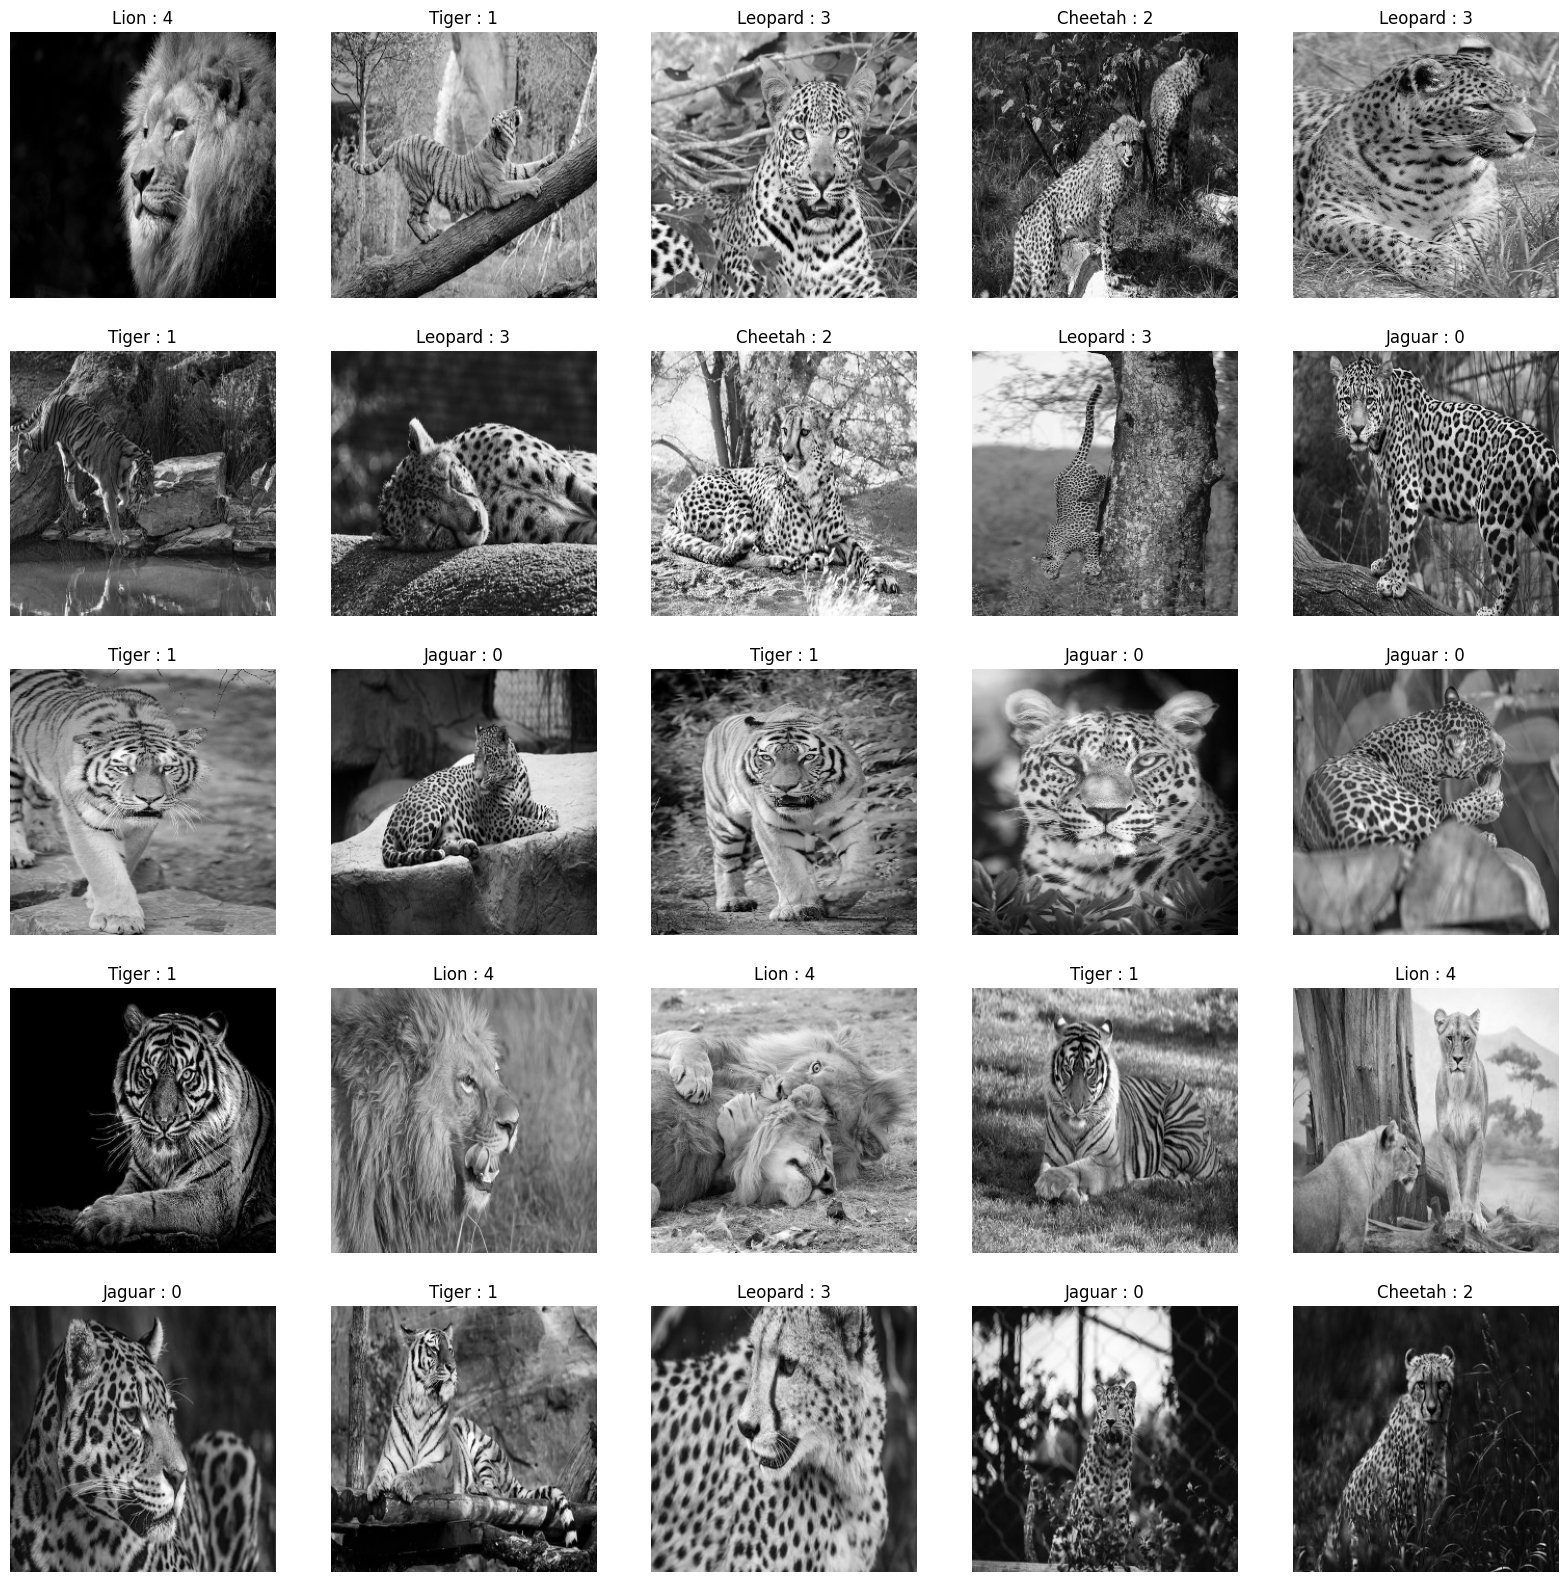

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

axes = axes.flatten()

for [imageArray, label], ax in zip(trainData, axes):
    ax.imshow(imageArray, cmap="gray")
    ax.set_title(f"{categories[label]} : {label}")
    ax.axis('off')

plt.show()

## Separating trainData into 5-Folds

In [8]:
folds = [trainData[i::5] for i in range(5)]
len(folds)

5

In [9]:
i = 1
print("5 Folds are: ")
for fold in folds:
    labels = [label for _, label in fold]
    print(f"{i}:")
    print(f"  Labels: {labels}")
    print(f"  Count: {len(fold)}\n")
    i += 1


5 Folds are: 
1:
  Labels: [4, 1, 1, 1, 0, 1, 0, 3, 0, 1, 2, 4, 4, 0, 1, 3, 3, 3, 1, 3, 4, 4, 0, 3, 4, 1, 1, 4, 1, 2, 3, 2, 4, 2]
  Count: 34

2:
  Labels: [1, 3, 0, 4, 1, 3, 4, 0, 2, 4, 2, 2, 4, 1, 0, 2, 0, 0, 2, 1, 3, 1, 3, 2, 1, 2, 3, 2, 2, 2, 4, 0, 0, 3]
  Count: 34

3:
  Labels: [3, 2, 1, 4, 3, 0, 2, 0, 1, 2, 4, 1, 3, 4, 2, 1, 1, 1, 3, 3, 3, 1, 3, 1, 2, 3, 3, 0, 4, 4, 0, 2, 0, 3]
  Count: 34

4:
  Labels: [2, 3, 0, 1, 0, 4, 2, 1, 2, 2, 0, 0, 1, 3, 3, 1, 2, 4, 4, 1, 0, 4, 0, 4, 2, 0, 4, 0, 2, 3, 2, 2, 2, 4]
  Count: 34

5:
  Labels: [3, 0, 0, 4, 2, 2, 2, 1, 1, 2, 4, 3, 2, 4, 4, 1, 2, 1, 1, 1, 3, 1, 4, 1, 1, 2, 3, 0, 0, 4, 1, 0, 2, 4]
  Count: 34



## Defining Function to calculate Euclidean Distance(L2)

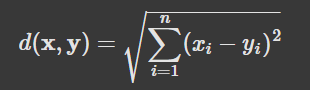

In [10]:
def distance(testImage, trainImage):
    return np.sqrt(np.sum(np.square(testImage - trainImage)))

## Prediction Function

In [11]:
def get_k_nearest_labels(distances, k=1):
    return [label for l, label in distances[:k]]

def find_most_common_label(labels):
    return Counter(labels).most_common(1)[0][0]

def prediction(distances, k=1):
    knn_labels = get_k_nearest_labels(distances, k)
    return find_most_common_label(knn_labels)

## Cross-Validation

In [12]:
def compute_distances(validation_image, training_set):
    distances = [(distance(validation_image[0], train_image[0]), train_image[1]) for train_image in training_set]
    return sorted(distances)

def calculate_fold_accuracy(validation_set, training_set, k):
    correct_count = 0
    for validation_image in validation_set:
        distances = compute_distances(validation_image, training_set)
        predicted_label = prediction(distances, k)
        if predicted_label == validation_image[1]:
            correct_count += 1
    return correct_count / len(validation_set)

def perform_cross_validation(data_folds, max_neighbors=30):
    foldAccuracies = []
    averageAccuracies = []

    for k in range(1, max_neighbors + 1):
        fold_accuracy_list = []
        for i in range(len(data_folds)):
            validation_set = data_folds[i]
            training_set = [item for j, fold in enumerate(data_folds) if j != i for item in fold]
            fold_accuracy = calculate_fold_accuracy(validation_set, training_set, k)
            fold_accuracy_list.append(fold_accuracy)

        foldAccuracies.append(fold_accuracy_list)
        averageAccuracy = sum(fold_accuracy_list) / len(fold_accuracy_list) #average accuracy
        averageAccuracies.append(averageAccuracy)
        print(f"Average Accuracy of K-{k} --> {averageAccuracy:.2f}")

    return foldAccuracies, averageAccuracies

# Running cross-validation
foldAccuracies, averageAccuracies = perform_cross_validation(folds)
print(f"Fold Accuracies: {foldAccuracies}")


Average Accuracy of K-1 --> 0.28
Average Accuracy of K-2 --> 0.28
Average Accuracy of K-3 --> 0.28
Average Accuracy of K-4 --> 0.32
Average Accuracy of K-5 --> 0.29
Average Accuracy of K-6 --> 0.29
Average Accuracy of K-7 --> 0.27
Average Accuracy of K-8 --> 0.26
Average Accuracy of K-9 --> 0.26
Average Accuracy of K-10 --> 0.25
Average Accuracy of K-11 --> 0.25
Average Accuracy of K-12 --> 0.23
Average Accuracy of K-13 --> 0.22
Average Accuracy of K-14 --> 0.24
Average Accuracy of K-15 --> 0.24
Average Accuracy of K-16 --> 0.25
Average Accuracy of K-17 --> 0.25
Average Accuracy of K-18 --> 0.24
Average Accuracy of K-19 --> 0.24
Average Accuracy of K-20 --> 0.26
Average Accuracy of K-21 --> 0.24
Average Accuracy of K-22 --> 0.21
Average Accuracy of K-23 --> 0.25
Average Accuracy of K-24 --> 0.25
Average Accuracy of K-25 --> 0.24
Average Accuracy of K-26 --> 0.25
Average Accuracy of K-27 --> 0.24
Average Accuracy of K-28 --> 0.25
Average Accuracy of K-29 --> 0.26
Average Accuracy of K-3

## Visualizing the Graph

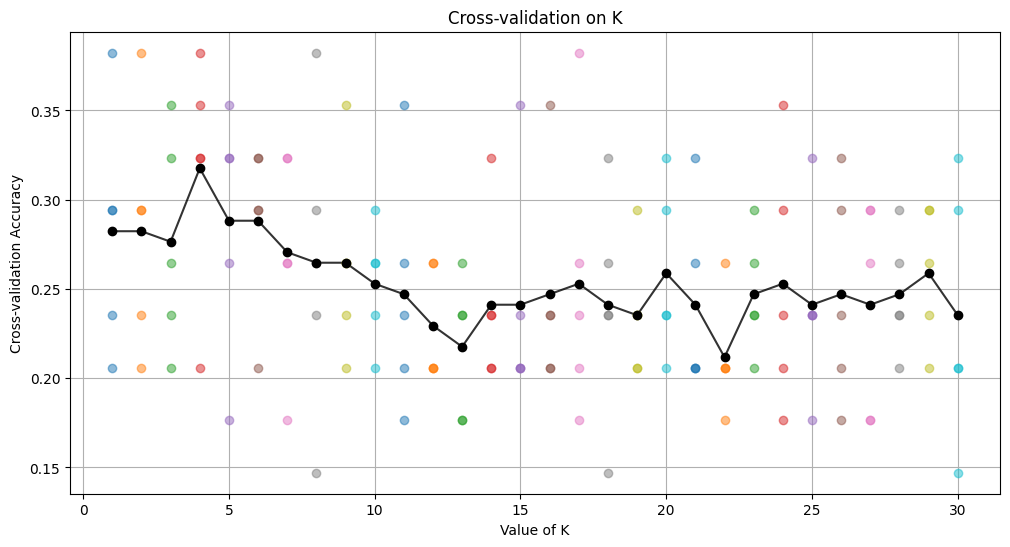

In [13]:
def plot_foldAccuracies(foldAccuracies):
    # Plot the individual fold accuracies as scatter points
    for k, accuracies in enumerate(foldAccuracies, start=1):
        plt.scatter([k] * len(accuracies), accuracies, zorder=5, alpha=0.5)

def plot_averageAccuracies(averageAccuracies):
    # Plot the average accuracies as green scatter points
    k_values = range(1, len(averageAccuracies) + 1)
    plt.scatter(k_values, averageAccuracies, color='black', zorder=10)
    plt.plot(k_values, averageAccuracies, color='black', alpha=0.8)

def plot_cross_validation_results(foldAccuracies, averageAccuracies):
    plt.figure(figsize=(12, 6))
    plot_foldAccuracies(foldAccuracies)
    plot_averageAccuracies(averageAccuracies)

    plt.xlabel('Value of K')
    plt.ylabel('Cross-validation Accuracy')
    plt.title('Cross-validation on K')
    plt.grid(True)
    plt.show()

# Plotting the results
plot_cross_validation_results(foldAccuracies, averageAccuracies)
